In [0]:
import numpy as np
import pandas as pd

In [0]:
#Metrics
def mean_square_error(y, y_pred):
    return np.mean(np.square(y - y_pred))

def root_mean_square_error(y, y_pred):
    return mean_square_error(y, y_pred)**0.5
  
def r2_score(y, y_pred):
    y_avg = y.mean()
    ss_total = np.sum(np.square(y - y_avg))
    ss_err = np.sum(np.square(y - y_pred))
    return 1 - ss_err/ss_total

In [0]:
#Utils
def add_biases(X):
    return np.hstack((X, np.ones((X.shape[0],1))))
  
def linear(X, w):
    return np.matmul(w, X.T)
  
def preprocess(X_train, X_test):
    #Standardize
    X_mean, X_std = X_train.mean(axis=0), X_train.std(axis=0)
    X_train = (X_train - X_mean)/X_std
    X_test = (X_test - X_mean)/X_std
    
    #Remove NaN in 37 column
    np.nan_to_num(X_train, copy=False)
    np.nan_to_num(X_test, copy=False)
    
    #Biases
    X_train = add_biases(X_train)
    X_test = add_biases(X_test)
    
    return X_train, X_test

In [0]:
#SGD  
def compute_gradient_on_batch(X, y, w):
  
    batch_size, feature_count = X.shape
    grad = np.zeros((batch_size, feature_count))
    
    for i in range(batch_size):
        grad[i, :] = X[i, :]*(w @ X[i] - y[i])
    
    return grad

def stochastic_gradient_descent(X, y, lr=1e-2, max_epoch=10, 
                                batch_size=1):
    weight_dist = np.inf
    w = np.random.randn(X.shape[1])    #init w
    errors = []
    
    iters = X.shape[0] // batch_size
    if (X.shape[0] % batch_size > 0):
        iters += 1
    
    for epoch in range(max_epoch):
        
        p = np.random.permutation(X.shape[0])
        X, y = X[p], y[p]    #Shuffle

        for i in range(iters):
            
            X_batch = X[i*batch_size:(i+1)*batch_size]
            y_batch = y[i*batch_size:(i+1)*batch_size]

            grad = compute_gradient_on_batch(X_batch, y_batch, w)
            w = w - lr * np.mean(grad, axis=0)
            
        errors.append(mean_square_error(y, linear(X, w)))
    
    return w, errors


In [0]:
#Folds
class KFolds:
    def __init__(self, X, y, k=5):
      
        self.k = k
        
        fold_size = X.shape[0]//k
        if X.shape[0] % k > 0:
            fold_size += 1
            
        self.X_folds = [X[i*fold_size:(i+1)*fold_size] for i in range(k)]
        self.y_folds = [y[i*fold_size:(i+1)*fold_size] for i in range(k)]
        
    def get_fold(self, fold_i):
        
        X_cv = self.X_folds[fold_i]
        y_cv = self.y_folds[fold_i]
        
        X_train = np.concatenate([self.X_folds[i] for i in range(self.k) if i != fold_i])
        y_train = np.concatenate([self.y_folds[i] for i in range(self.k) if i != fold_i])
        
        return X_train, y_train, X_cv, y_cv

In [6]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00363/Dataset.zip
!unzip -q Dataset.zip

--2019-09-16 09:32:42--  https://archive.ics.uci.edu/ml/machine-learning-databases/00363/Dataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19055526 (18M) [application/x-httpd-php]
Saving to: ‘Dataset.zip’

Dataset.zip         100%[===================>]  18.17M  36.6MB/s    in 0.5s    

2019-09-16 09:32:43 (36.6 MB/s) - ‘Dataset.zip’ saved [19055526/19055526]



In [0]:
train_df = pd.read_csv('Dataset/Training/Features_Variant_1.csv',header=None)

data = train_df.values
random.shuffle(data)
y = data[:,-1]
X = data[:,:-1]

In [129]:
kfold = KFolds(X,y,k=5)
rmse_list = []
r2_list = []
weights_list = []
errors_list = []

for i in range(kfold.k):
    X_train, y_train, X_cv, y_cv = kfold.get_fold(i)
    X_train, X_cv = preprocess(X_train, X_cv)
    
    w, errors = stochastic_gradient_descent(X_train, y_train, lr=1e-2, max_epoch=25, batch_size=1000)
    y_pred = linear(X_cv, w)
    
    rmse_list.append(root_mean_square_error(y_cv, y_pred))
    r2_list.append(r2_score(y_cv, y_pred))
    weights_list.append(w)
    errors_list.append(errors)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [130]:
print("Folds\t│{}\t{}\t{}\t{}\t{}\t│mean\tstd".format(*range(1,kfold.k+1)))
print("────────┼───────────────────────────────────────┼─────────────")
print("RMSE\t│{:.1f}\t{:.1f}\t{:.1f}\t{:.1f}\t{:.1f}\t│{:.2f}\t{:.2f}".format(*rmse_list, np.array(rmse_list).mean(), np.array(rmse_list).std()))
print("R2\t│{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t│{:.3f}\t{:.3f}".format(*r2_list, np.array(r2_list).mean(), np.array(r2_list).std()))

Folds	│1	2	3	4	5	│mean	std
────────┼───────────────────────────────────────┼─────────────
RMSE	│27.9	31.7	32.1	28.7	28.6	│29.81	1.76
R2	│0.263	0.318	0.321	0.228	0.306	│0.287	0.036


In [131]:
weights_list = np.array(weights_list)
print("────────┼───────────────────────────────────────┼─────────────")
for feat in range(53):
    print("{}\t│{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t│".format(feat+1, *weights_list[:,feat]))
print("bias\t│{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t│".format(*weights_list[:,-1]))

────────┼───────────────────────────────────────┼─────────────
1	│-0.027	0.686	0.186	-2.157	0.318	│
2	│-0.633	-0.519	-0.509	-0.600	-0.585	│
3	│-1.264	-1.827	-1.214	-0.514	-1.950	│
4	│-0.004	-0.073	-0.042	-0.086	-0.109	│
5	│-0.031	0.445	-0.540	0.635	0.096	│
6	│1.126	-0.706	-0.211	0.738	1.961	│
7	│-0.860	1.145	0.759	-0.048	0.147	│
8	│0.996	-0.826	-0.170	0.208	0.222	│
9	│2.278	1.483	2.124	0.553	2.991	│
10	│-0.724	-1.132	-1.848	0.556	-1.688	│
11	│-0.193	-0.072	0.709	-0.841	-1.286	│
12	│1.809	2.245	1.295	0.327	0.802	│
13	│2.647	2.024	2.990	2.550	3.611	│
14	│1.538	-0.641	-0.512	0.409	0.214	│
15	│-0.233	0.328	0.291	-0.130	0.125	│
16	│0.234	-0.302	0.985	-0.149	0.084	│
17	│0.444	1.246	0.660	1.186	0.674	│
18	│2.979	2.655	1.227	3.162	2.586	│
19	│-0.174	-1.129	0.490	1.077	0.523	│
20	│-0.318	-1.071	0.329	-0.728	-0.388	│
21	│-0.731	0.346	-0.435	-0.173	-2.004	│
22	│0.266	-1.602	-2.105	-0.753	0.332	│
23	│-0.454	0.236	0.654	-1.299	-0.767	│
24	│-0.330	1.349	1.025	-0.389	-0.564	│
25	│-0.486	-1.183	0.499	

Populating the interactive namespace from numpy and matplotlib


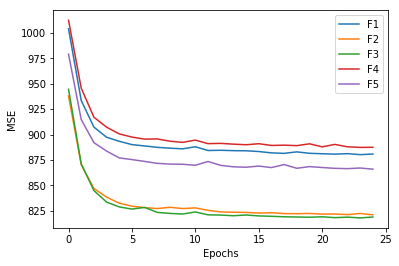

In [132]:
%pylab inline
errors_list = np.array(errors_list)
plt.plot(errors_list.T)
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend(['F1','F2','F3','F4','F5']);